In [111]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import io

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras



In [112]:
# Load the dataframes 

aic_art_imgs = pd.read_csv("aic_images.csv")
wiki_art_imgs = pd.read_csv("wikiart_df.csv")

In [113]:
aic_art_imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122 entries, 0 to 4121
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   artwork_type_title  4122 non-null   object
 1   style_title         4122 non-null   object
 2   id                  4122 non-null   int64 
 3   image_id            4122 non-null   object
 4   title               4122 non-null   object
 5   search_term         4122 non-null   object
 6   file_name           4122 non-null   object
dtypes: int64(1), object(6)
memory usage: 225.5+ KB


In [114]:
wiki_art_imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                4314 non-null   object 
 1   title             4314 non-null   object 
 2   url               4314 non-null   object 
 3   artistUrl         4314 non-null   object 
 4   artistName        4314 non-null   object 
 5   artistId          4314 non-null   object 
 6   completitionYear  4313 non-null   float64
 7   width             4314 non-null   int64  
 8   image             4314 non-null   object 
 9   height            4314 non-null   int64  
 10  Style             4254 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 370.9+ KB


Check and clean the wiki art file images and df, the aic dataframe was already checked in
its data collection notebook.

In [115]:
# Create file_name column by adding .jpg extension to id
wiki_art_imgs['file_name'] = wiki_art_imgs['id'] + '.jpg'
print("file_name column added.")

# Check which files exist in the directory
image_dir = 'downloaded_images_wikiart'
exists_mask = wiki_art_imgs['file_name'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))

# Filter to keep only rows where files exist
wiki_art_imgs = wiki_art_imgs[exists_mask]

# Let's check if there are any duplicates while we're at it
duplicate_count = wiki_art_imgs['file_name'].duplicated().sum()

if duplicate_count > 0:
    print(f"Found {duplicate_count} duplicate entries")
else:
    print("No duplicate filenames found.")

file_name column added.
No duplicate filenames found.


In [116]:
wiki_art_imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                4314 non-null   object 
 1   title             4314 non-null   object 
 2   url               4314 non-null   object 
 3   artistUrl         4314 non-null   object 
 4   artistName        4314 non-null   object 
 5   artistId          4314 non-null   object 
 6   completitionYear  4313 non-null   float64
 7   width             4314 non-null   int64  
 8   image             4314 non-null   object 
 9   height            4314 non-null   int64  
 10  Style             4254 non-null   object 
 11  file_name         4314 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 404.6+ KB


In [117]:
# Drop columns that are not needed

wiki_art_imgs = wiki_art_imgs.drop(columns=['id','title','url','artistUrl','artistName','artistId','completitionYear',
                                            'width','image','height'])
aic_art_imgs = aic_art_imgs.drop(columns=['artwork_type_title','id','image_id','title','style_title'])

In [118]:
imgs = pd.concat([wiki_art_imgs, aic_art_imgs], axis=0, ignore_index=True)

In [119]:
imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8436 entries, 0 to 8435
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Style        4254 non-null   object
 1   file_name    8436 non-null   object
 2   search_term  4122 non-null   object
dtypes: object(3)
memory usage: 197.8+ KB


### Standardize the styles to use for classification

In [120]:

imgs['Style'].value_counts()

Style
Art Informel              568
Cubism                    561
Abstract Expressionism    557
Conceptual Art            535
Expressionism             515
Contemporary              494
Baroque                   359
Contemporary Realism      346
Early Renaissance         319
Name: count, dtype: int64

In [121]:
imgs['search_term'].value_counts()

search_term
Modern Art                617
ukiyo-e                   536
Pop Art                   476
Mannerism                 382
Post-Impressionism        304
Cubism                    260
Realism                   195
early renaissance         123
neo-romantic              122
late renaissance          118
Baroque                   106
abstract figures           98
northern renaissance       88
Abstract Expressionism     83
Art Informel               59
Surrealism                 56
Conceptual Art             54
Modernism                  52
Rococo                     45
abstract patterns          44
high renaissance           43
mannerism                  42
Symbolism                  35
abstract objects           33
Fauvism                    22
abstract motifs            22
contemporary               19
abstract shapes            18
abstract imagist           15
abstract forms             11
lyrical abstraction        11
Neoclassicism               7
Abstract                    

In [122]:

def clean_art_styles(df):
    """
    Cleans art styles in a dataframe by:
    1. Dropping rows where search_term contains 'abstract' (except 'Abstract Expressionism')
    2. Capitalizing first letter of each word in search_term
    3. Filling empty Style values with search_term values
    
    Parameters:
    df (pandas.DataFrame): DataFrame with 'search_term' and 'Style' columns
    
    Returns:
    pandas.DataFrame: Cleaned DataFrame
    """
    # Create a copy of the DataFrame
    df = df.copy()
    
    # Drop rows containing 'abstract' except 'Abstract Expressionism'
    # First, create a mask for rows containing 'abstract'
    abstract_mask = df['search_term'].fillna('').str.contains('abstract', case=False)

    # Then, create a mask for rows containing 'Abstract Expressionism'
    expressionism_mask = df['search_term'].fillna('').str.contains('Abstract Expressionism', case=False)
    
    # Keep rows that either don't contain 'abstract' or contain 'Abstract Expressionism'
    df = df[~abstract_mask | expressionism_mask]
    
    # Capitalize first letter of each word in search_term
    df['search_term'] = df['search_term'].apply(lambda x: ' '.join(word.capitalize() for word in x.split()) if isinstance(x, str) else x)
    
    # Fill empty Style values with search_term values
    df.loc[df['Style'].isna(), 'Style'] = df.loc[df['Style'].isna(), 'search_term']
    
    return df


# Usage

imgs_cleaned = clean_art_styles(imgs)
imgs_cleaned= imgs_cleaned.reset_index(drop=True)

In [123]:
imgs_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8176 entries, 0 to 8175
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Style        8116 non-null   object
 1   file_name    8176 non-null   object
 2   search_term  3862 non-null   object
dtypes: object(3)
memory usage: 191.8+ KB


In [124]:
# Drop the search_term column
imgs_cleaned = imgs_cleaned.drop(columns='search_term')
# Drop any remaining entries that don't have a Style term
imgs_cleaned = imgs_cleaned.dropna()


In [125]:
imgs_cleaned['Style'].value_counts()

Style
Cubism                    821
Abstract Expressionism    640
Art Informel              627
Modern Art                617
Conceptual Art            589
Ukiyo-e                   536
Expressionism             519
Contemporary              513
Pop Art                   476
Baroque                   465
Early Renaissance         442
Mannerism                 424
Contemporary Realism      346
Post-impressionism        304
Realism                   195
Neo-romantic              122
Late Renaissance          118
Northern Renaissance       88
Surrealism                 56
Modernism                  52
Rococo                     45
High Renaissance           43
Symbolism                  37
Fauvism                    22
Neoclassicism               7
Modernist                   4
Romantic                    4
Op Art                      3
Minimalism                  1
Name: count, dtype: int64

In [126]:
# Drop Styles with too few entries
# Filter the 'Style' column based on value counts
style_counts = imgs_cleaned['Style'].value_counts()

# Keep only the styles that occur more than 10 times
imgs_filtered = imgs_cleaned[imgs_cleaned['Style'].isin(style_counts[style_counts > 10].index)]


In [127]:
# Reset the index and sanity check our dataset
imgs_filtered = imgs_filtered.reset_index(drop=True)
imgs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8097 entries, 0 to 8096
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Style      8097 non-null   object
 1   file_name  8097 non-null   object
dtypes: object(2)
memory usage: 126.6+ KB


Calculate basic statistics (# of classes, images per class, image sizes)

In [128]:
imgs_filtered['Style'].value_counts()

Style
Cubism                    821
Abstract Expressionism    640
Art Informel              627
Modern Art                617
Conceptual Art            589
Ukiyo-e                   536
Expressionism             519
Contemporary              513
Pop Art                   476
Baroque                   465
Early Renaissance         442
Mannerism                 424
Contemporary Realism      346
Post-impressionism        304
Realism                   195
Neo-romantic              122
Late Renaissance          118
Northern Renaissance       88
Surrealism                 56
Modernism                  52
Rococo                     45
High Renaissance           43
Symbolism                  37
Fauvism                    22
Name: count, dtype: int64

Visualization of Art Style distribution before augmentation.

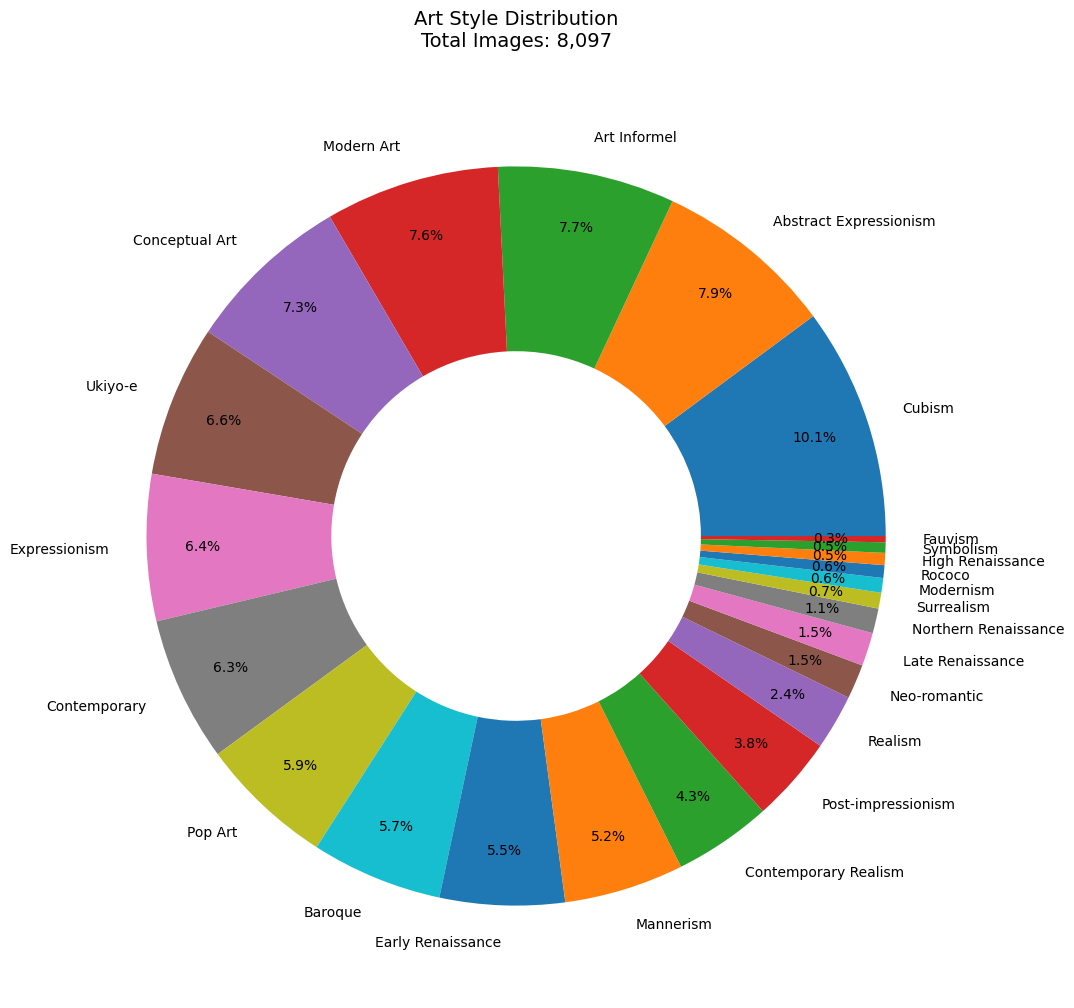

In [129]:
def plot_style_pie(df):
    """
    Creates a pie chart of art style distribution using matplotlib
    """
    plt.figure(figsize=(12, 12))
    
    # Get style counts and total
    style_counts = df['Style'].value_counts()
    total_images = len(df)
    
    # Create pie chart
    plt.pie(style_counts.values, 
            labels=style_counts.index,
            autopct='%1.1f%%',
            pctdistance=0.85,
            wedgeprops=dict(width=0.5))  # Creates donut effect
    
    plt.title(f"Art Style Distribution\nTotal Images: {total_images:,}", 
              pad=20, 
              size=14)
    
    return plt

#Usage:
plot_style_pie(imgs_filtered)
plt.show()

### Image Preprocessing
- Resizing to standard sizes
- Convert floating point arrays
- Normalize 
- Augment the images to address class imbalance

In [130]:
def check_image_sizes_and_update_paths(df):
    """
    Checks image sizes and updates file paths so we don't have to search
    two directories.
    """
    df = df.copy()
    image_sizes = set()
    df['file_path'] = None
    
    for i, row in tqdm(df.iterrows()):
        filename = row['file_name']
        for directory in ['downloaded_images_wikiart', 'downloaded_images_aic']:
            path = os.path.join(directory, filename)
            if os.path.exists(path):
                with Image.open(path) as img:
                    image_sizes.add(img.size)
                df.loc[i, 'file_path'] = path
                break
    df = df.drop(columns='file_name')
    return image_sizes, df

In [131]:
size_list, imgs_filtered = check_image_sizes_and_update_paths(imgs_filtered)
size_list

8097it [00:14, 541.82it/s] 


{(339, 481),
 (1649, 2250),
 (843, 1183),
 (843, 954),
 (432, 300),
 (843, 545),
 (480, 493),
 (3000, 2113),
 (2162, 3000),
 (843, 1448),
 (2723, 2250),
 (446, 500),
 (431, 600),
 (1728, 2250),
 (843, 1039),
 (435, 570),
 (843, 810),
 (750, 582),
 (569, 570),
 (3000, 2149),
 (636, 480),
 (666, 768),
 (500, 556),
 (391, 420),
 (843, 1075),
 (1717, 3000),
 (512, 301),
 (464, 490),
 (382, 600),
 (3000, 2414),
 (530, 435),
 (450, 326),
 (843, 666),
 (750, 438),
 (3000, 1102),
 (1371, 3000),
 (1505, 3000),
 (843, 1340),
 (453, 480),
 (614, 434),
 (640, 306),
 (3000, 2499),
 (2326, 3000),
 (461, 600),
 (750, 474),
 (199, 600),
 (2478, 2868),
 (1584, 3000),
 (2541, 2250),
 (600, 535),
 (547, 380),
 (586, 600),
 (843, 1196),
 (398, 400),
 (843, 2099),
 (288, 385),
 (475, 391),
 (750, 559),
 (674, 600),
 (412, 600),
 (1275, 2250),
 (843, 378),
 (554, 275),
 (580, 413),
 (639, 499),
 (465, 575),
 (2530, 3000),
 (416, 570),
 (843, 1052),
 (418, 500),
 (750, 595),
 (496, 599),
 (483, 480),
 (3000,

In [132]:
def letterbox_resize(image, target_size):
    """
    Resize an image to a square target size while maintaining aspect ratio using letterboxing.
    """
    w, h = image.size
    ratio = min(target_size / w, target_size / h)  # Maintain aspect ratio without shrinking too much
    
    new_w = int(w * ratio)
    new_h = int(h * ratio)
    
    # Resize the image
    resized = image.resize((new_w, new_h), Image.LANCZOS)
    
    # Create a black square image of target size
    new_image = Image.new('RGB', (target_size, target_size), (0, 0, 0))
    
    # Calculate padding
    x_offset = (target_size - new_w) // 2
    y_offset = (target_size - new_h) // 2
    
    # Paste the resized image into the center of the black background
    new_image.paste(resized, (x_offset, y_offset))
    
    return new_image

In [133]:
# Function to process each image, save to directory, and return new path
def process_image(row):
    # Load the image
    img = Image.open(row['file_path'])
    
    # Resize image
    resized_img = letterbox_resize(img, target_size=256)
    
    # Get original filename from path and create new path
    filename = os.path.basename(row['file_path'])
    new_path = os.path.join('resized_imgs', filename)
    
    # Save the resized image
    resized_img.save(new_path)
    
    return new_path

# Apply the processing to each row and update file_path
imgs_filtered['file_path'] = imgs_filtered.apply(process_image, axis=1)

In [134]:
# Checking new file path
imgs_filtered['file_path'].head()

0    resized_imgs\57727febedc2cb3880ef67d0.jpg
1    resized_imgs\57726e1dedc2cb3880b5fd49.jpg
2    resized_imgs\57726e26edc2cb3880b60d68.jpg
3    resized_imgs\57726e1dedc2cb3880b5fd89.jpg
4    resized_imgs\57726e1dedc2cb3880b5fdb9.jpg
Name: file_path, dtype: object

In [135]:
# Convert to floating point and normalize
def load_and_normalize_image(file_path):
    """
    Load image from file_path, convert to float32 array and normalize to [0, 1] range
    
    Args:
        file_path (str): Path to the image file
        
    Returns:
        numpy.ndarray: Normalized image array of shape (height, width, 3) in float32
    """
    # Load image
    img = Image.open(file_path)
    
    # Convert to RGB if not already
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert to numpy array and change type to float32
    img_array = np.array(img, dtype=np.float32)
    
    # Normalize to [0, 1] range
    img_array = img_array / 255.0
    
    return img_array

# Apply to the DataFrame to create a new column with normalized arrays
imgs_filtered['image_array'] = imgs_filtered['file_path'].apply(load_and_normalize_image)

In [136]:
# Get class distribution
class_counts = imgs_filtered['Style'].value_counts()
target_count = 150

# Create augmentation generator with our specific parameters
datagen = ImageDataGenerator(
   rotation_range=10,
   brightness_range=[0.9, 1.1],
   fill_mode='nearest',
   cval=0
)

def augment_and_save_image(img_array, original_path, num_augmentations):
    """
    Create and save augmented versions of an image with debugging information
    """
    new_paths = []
    base_name = os.path.splitext(os.path.basename(original_path))[0]
    ext = os.path.splitext(original_path)[1]
    
    if num_augmentations <= 0:
        return new_paths
    
    # Print initial image stats
    print(f"\nProcessing image: {base_name}")
    print(f"Initial image mean pixel value: {np.mean(img_array):.3f}")
    
    contrast_layer = tf.keras.layers.RandomContrast(0.1)
    img_expanded = np.expand_dims(img_array, 0)
    
    for i in range(num_augmentations):
        print(f"\nAugmentation {i+1}:")
        
        # ImageDataGenerator augmentation
        aug_img = next(datagen.flow(
            img_expanded,
            batch_size=1
        ))[0]
        print(f"After ImageDataGenerator: mean={np.mean(aug_img):.3f}, min={np.min(aug_img):.3f}, max={np.max(aug_img):.3f}")
        
        # Contrast adjustment
        aug_img = contrast_layer(aug_img)
        print(f"After contrast adjustment: mean={np.mean(aug_img):.3f}, min={np.min(aug_img):.3f}, max={np.max(aug_img):.3f}")
        
        # Clip values
        aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)
        print(f"After first clip: mean={np.mean(aug_img):.3f}, min={np.min(aug_img):.3f}, max={np.max(aug_img):.3f}")
        
        # Cropping
        h, w = aug_img.shape[:2]
        crop_size = int(min(h, w) * 0.8)
        start_h = np.random.randint(0, h - crop_size + 1)
        start_w = np.random.randint(0, w - crop_size + 1)
        aug_img = aug_img[start_h:start_h+crop_size, start_w:start_w+crop_size]
        print(f"After cropping: mean={np.mean(aug_img):.3f}, min={np.min(aug_img):.3f}, max={np.max(aug_img):.3f}")
        
        # Resize
        aug_img = tf.image.resize(aug_img, (256, 256))
        print(f"After resize: mean={np.mean(aug_img):.3f}, min={np.min(aug_img):.3f}, max={np.max(aug_img):.3f}")
        
        # Final clip
        aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)
        print(f"After final clip: mean={np.mean(aug_img):.3f}, min={np.min(aug_img):.3f}, max={np.max(aug_img):.3f}")
        
        # Convert to uint8
        aug_img = (aug_img * 255).numpy().astype(np.uint8)
        print(f"After uint8 conversion: mean={np.mean(aug_img):.3f}, min={np.min(aug_img)}, max={np.max(aug_img)}")
        
        # Check darkness
        if np.mean(aug_img) < 10:
            print(f"Warning: Image too dark, skipping")
            continue
        
        new_filename = f"{base_name}_aug_{i+1}{ext}"
        new_path = os.path.join('resized_imgs', new_filename)
        
        try:
            Image.fromarray(aug_img).save(new_path)
            new_paths.append(new_path)
        except Exception as e:
            print(f"Error saving augmented image {new_filename}: {str(e)}")
            continue
            
    return new_paths

# Initialize DataFrame for augmented images
new_rows = []

# Process each class that needs augmentation
print("\nStarting augmentation process:")
for style, count in class_counts.items():
    if count < target_count:
        print(f"\nProcessing {style}: Current count = {count}, Target = {target_count}")
        
        # Get DataFrame slice for current style
        style_df = imgs_filtered[imgs_filtered['Style'] == style]
        num_needed = target_count - count
        
        # Calculate augmentations needed per image
        augs_per_image = int(np.ceil(num_needed / len(style_df)))
        
        print(f"Need {num_needed} new images, planning {augs_per_image} augmentations per image")
        
        current_new_count = 0
        
        # Process each image in the current style
        for _, row in style_df.iterrows():
            # Calculate remaining augmentations needed for this class
            remaining_needed = target_count - (count + current_new_count)
            
            if remaining_needed <= 0:
                break
                
            # Calculate how many augmentations to create for this specific image
            augs_this_image = min(augs_per_image, remaining_needed)
            
            # Create augmented versions
            aug_paths = augment_and_save_image(
                row['image_array'],
                row['file_path'],
                augs_this_image
            )
            
            # Update counter and create new rows
            current_new_count += len(aug_paths)
            
            for aug_path in aug_paths:
                try:
                    new_image_array = load_and_normalize_image(aug_path)
                    new_rows.append({
                        'Style': style,
                        'file_path': aug_path,
                        'image_array': new_image_array
                    })
                except Exception as e:
                    print(f"Error loading augmented image {aug_path}: {str(e)}")
                    continue
            
        
        print(f"Finished {style}: Created {current_new_count} new images total")

# Add augmented images to DataFrame
print(f"\nTotal number of augmented images created: {len(new_rows)}")

if len(new_rows) > 0:
    augmented_df = pd.DataFrame(new_rows)
    imgs_filtered = pd.concat([imgs_filtered, augmented_df], ignore_index=True)
    print("Successfully added augmented images to DataFrame")
else:
    print("Warning: No augmented images were created!")


Starting augmentation process:

Processing Neo-romantic: Current count = 122, Target = 150
Need 28 new images, planning 1 augmentations per image

Processing image: 6006b9e7-567a-4fb8-34e2-a120886690fe
Initial image mean pixel value: 0.174



Augmentation 1:
After ImageDataGenerator: mean=0.000, min=0.000, max=0.000
After contrast adjustment: mean=0.000, min=0.000, max=0.000
After first clip: mean=0.000, min=0.000, max=0.000
After cropping: mean=0.000, min=0.000, max=0.000
After resize: mean=0.000, min=0.000, max=0.000
After final clip: mean=0.000, min=0.000, max=0.000
After uint8 conversion: mean=0.000, min=0, max=0

Processing image: f2cf5f64-7c25-7d20-42a2-bd371ee9f68b
Initial image mean pixel value: 0.349

Augmentation 1:
After ImageDataGenerator: mean=0.000, min=0.000, max=0.000
After contrast adjustment: mean=0.000, min=0.000, max=0.000
After first clip: mean=0.000, min=0.000, max=0.000
After cropping: mean=0.000, min=0.000, max=0.000
After resize: mean=0.000, min=0.000, max=0.000
After final clip: mean=0.000, min=0.000, max=0.000
After uint8 conversion: mean=0.000, min=0, max=0

Processing image: 3f0cd83f-84db-23e9-fb41-286de4bdae62
Initial image mean pixel value: 0.190

Augmentation 1:
After ImageDataGenerator: mea

In [137]:
imgs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Style        8100 non-null   object
 1   file_path    8100 non-null   object
 2   image_array  8100 non-null   object
dtypes: object(3)
memory usage: 190.0+ KB


In [138]:
imgs_filtered['Style'].value_counts()

Style
Cubism                    821
Abstract Expressionism    640
Art Informel              627
Modern Art                617
Conceptual Art            589
Ukiyo-e                   536
Expressionism             519
Contemporary              513
Pop Art                   476
Baroque                   465
Early Renaissance         442
Mannerism                 424
Contemporary Realism      346
Post-impressionism        304
Realism                   195
Neo-romantic              122
Late Renaissance          118
Northern Renaissance       88
Surrealism                 56
Modernism                  53
Rococo                     47
High Renaissance           43
Symbolism                  37
Fauvism                    22
Name: count, dtype: int64

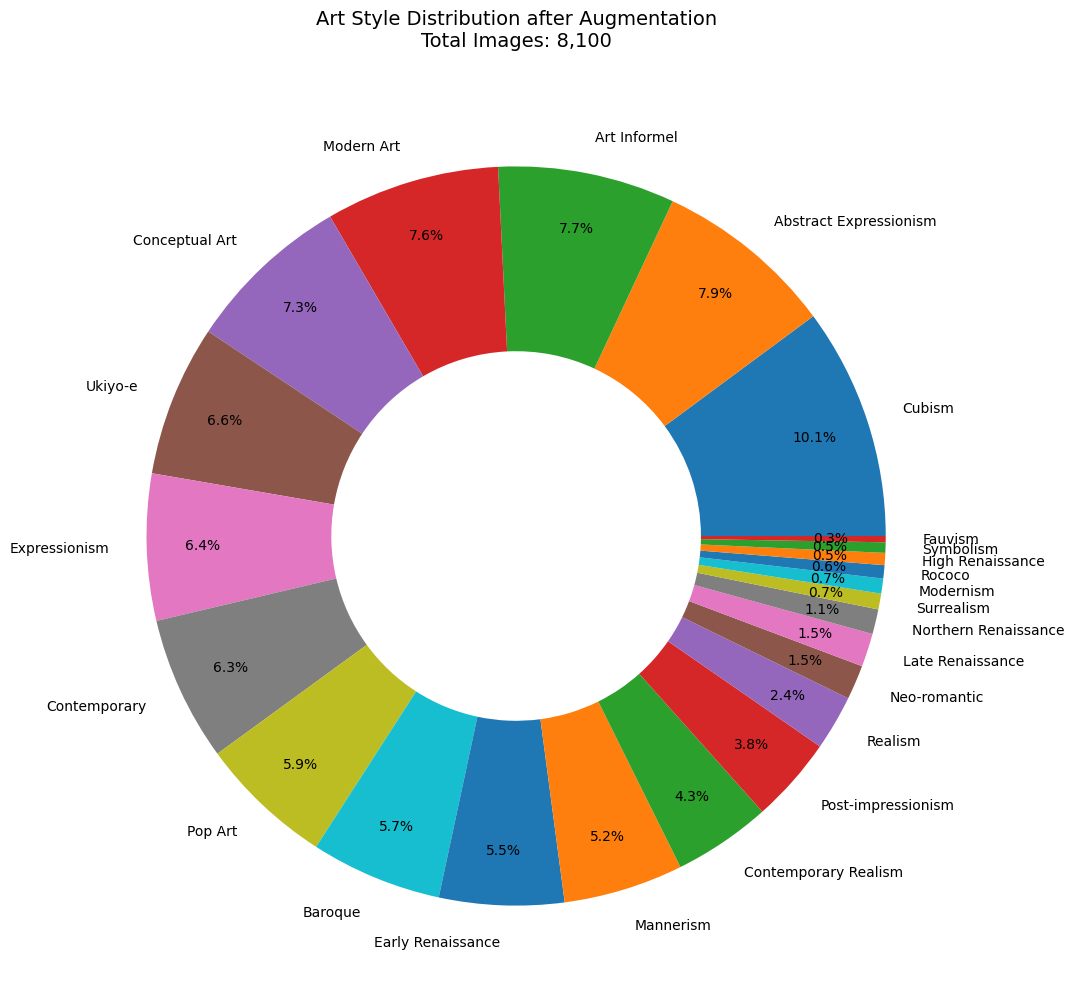

In [139]:
def plot_style_pie(df):
    """
    Creates a pie chart of art style distribution using matplotlib
    """
    plt.figure(figsize=(12, 12))
    
    # Get style counts and total
    style_counts = df['Style'].value_counts()
    total_images = len(df)
    
    # Create pie chart
    plt.pie(style_counts.values, 
            labels=style_counts.index,
            autopct='%1.1f%%',
            pctdistance=0.85,
            wedgeprops=dict(width=0.5))  # Creates donut effect
    
    plt.title(f"Art Style Distribution after Augmentation\nTotal Images: {total_images:,}", 
              pad=20, 
              size=14)
    
    return plt

#Usage:
plot_style_pie(imgs_filtered)
plt.show()

In [140]:
# Drop the numpy arrays as saving the file would be too big. We'll keep the file_path
# and process the images into arrays during training.
imgs_filtered = imgs_filtered.drop('image_array', axis=1)

# Verify the new structure
imgs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Style      8100 non-null   object
 1   file_path  8100 non-null   object
dtypes: object(2)
memory usage: 126.7+ KB


In [141]:
imgs_filtered.to_csv('training_imageset.csv', index=False)